In [1]:
import pandas as pd 
import numpy as np 

In [2]:
df_credits = pd.read_csv('tmdb_5000_credits.csv')
df_movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
df_credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [4]:
df_movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [5]:
# 欄位更名合併。
df_credits.columns = ['id','tittle','cast','crew']
df = df_credits.merge(df_movies,on = 'id')
df.head(1)

,id,tittle,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4803 non-null   int64  
 1   tittle                4803 non-null   object 
 2   cast                  4803 non-null   object 
 3   crew                  4803 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   keywords              4803 non-null   object 
 8   original_language     4803 non-null   object 
 9   original_title        4803 non-null   object 
 10  overview              4800 non-null   object 
 11  popularity            4803 non-null   float64
 12  production_companies  4803 non-null   object 
 13  production_countries  4803 non-null   object 
 14  release_date          4802 non-null   object 
 15  revenue              

# 直接用資料數據來推薦
## 1-1 高評價電影 Top 5

In [ ]:
# 參考 IMDB 權重評分公式
# v 是電影的票數
# m 是入榜的最低票數
# R 是電影的平均評分
# C 是整份資料的平均投票數

$$ Weighted Rating(WR) = (\frac{v}{v+m})\times R + (\frac{m}{v+m})\times C $$

In [7]:
C= df['vote_average'].mean()
C

6.092171559442011

In [8]:
# 設定得票數超過其他 90% 的電影為上榜門檻。
m= df['vote_count'].quantile(0.9)
m

1838.4000000000015

In [9]:
# 符合門檻的電影數（481部）
q_movies = df.copy().loc[df['vote_count'] >= m]
q_movies.shape

(481, 23)

In [10]:
# 參考上面 IMDB 的權重公式
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v+m) * R) + (m / (m+v) * C)

In [11]:
# 新增一欄 '權重分數' 
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

# 權重分數降序排列
q_movies = q_movies.sort_values('score', ascending=False)

# Top 5 高評價電影
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239


## 1-2 受歡迎電影 Top5 (Popularity)

Text(0.5, 1.0, 'Popular Movies')

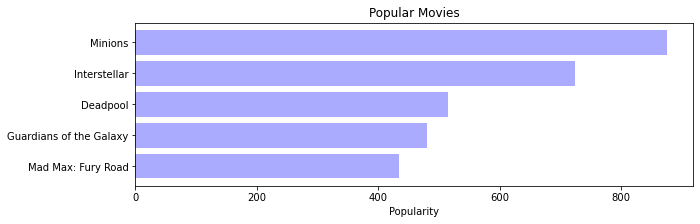

In [12]:
import matplotlib.pyplot as plt

pop = df.sort_values('popularity', ascending=False)
plt.figure(figsize=(10,3))
plt.barh(pop['title'].head(5),pop['popularity'].head(5), align='center', color='#AAAAFF')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# 分析後推薦
## 2-1 簡介相似度電影推薦

In [13]:
for i in range(3):
    print(df['overview'][i])

In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.
Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.
A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# 下載 NLTK 英語斷詞包
# nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

# 設定斷詞
tfidf = TfidfVectorizer(stop_words= stopwords)

# 空字串補空值
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])
tfidf_matrix.shape

(4803, 21123)

In [ ]:
# print(stopwords[:10])

In [15]:
from sklearn.metrics.pairwise import linear_kernel

# 計算餘弦相似度
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# 給電影標題
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [16]:
# 定義最相似電影
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # 餘弦相似度得分
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 扣掉第一名（自己），列出前 10
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [17]:
get_recommendations('Toy Story 3')

1541                 Toy Story
343                Toy Story 2
1779    The 40 Year Old Virgin
891            Man on the Moon
3065                Heartbeeps
3379              Factory Girl
3873             Class of 1984
4387      A LEGO Brickumentary
699             Daddy Day Care
1191            Small Soldiers
Name: title, dtype: object

In [18]:
get_recommendations('Toy Story')

42                 Toy Story 3
343                Toy Story 2
1779    The 40 Year Old Virgin
891            Man on the Moon
2869    For Your Consideration
3379              Factory Girl
3873             Class of 1984
3065                Heartbeeps
3383                 Losin' It
2569               Match Point
Name: title, dtype: object

> Toy Story 系列以外的推薦都怪怪的..  
再加上更多特徵去計算

## 2-2 用導演、演員相似度來推薦


In [19]:
# 將字串還原成它能夠轉化成的資料型別
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [20]:
# 先看一下工作人員 list 長怎樣
df['crew'][42][:3]

[{'credit_id': '5770143fc3a3683733000f3a',
  'department': 'Writing',
  'gender': 2,
  'id': 7,
  'job': 'Story',
  'name': 'Andrew Stanton'},
 {'credit_id': '52fe433f9251416c75009141',
  'department': 'Directing',
  'gender': 2,
  'id': 8,
  'job': 'Director',
  'name': 'Lee Unkrich'},
 {'credit_id': '5770145492514157a60011c6',
  'department': 'Writing',
  'gender': 2,
  'id': 8,
  'job': 'Story',
  'name': 'Lee Unkrich'}]

In [21]:
df['cast'][42][:5]

[{'cast_id': 6,
  'character': 'Woody (voice)',
  'credit_id': '52fe433f9251416c7500915d',
  'gender': 2,
  'id': 31,
  'name': 'Tom Hanks',
  'order': 0},
 {'cast_id': 9,
  'character': 'Buzz Lightyear (voice)',
  'credit_id': '52fe433f9251416c75009169',
  'gender': 2,
  'id': 12898,
  'name': 'Tim Allen',
  'order': 1},
 {'cast_id': 17,
  'character': 'Lotso (voice)',
  'credit_id': '52fe433f9251416c75009185',
  'gender': 2,
  'id': 13726,
  'name': 'Ned Beatty',
  'order': 2},
 {'cast_id': 8,
  'character': 'Jessie the Yodeling Cowgirl (voice)',
  'credit_id': '52fe433f9251416c75009165',
  'gender': 1,
  'id': 3234,
  'name': 'Joan Cusack',
  'order': 3},
 {'cast_id': 7,
  'character': 'Ken (voice)',
  'credit_id': '52fe433f9251416c75009161',
  'gender': 2,
  'id': 2232,
  'name': 'Michael Keaton',
  'order': 4}]

In [22]:
df['keywords'][42][:5]

[{'id': 1562, 'name': 'hostage'},
 {'id': 3616, 'name': 'college'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5462, 'name': 'barbie'},
 {'id': 10336, 'name': 'animation'}]

In [23]:
df['genres'][42][:5]

[{'id': 16, 'name': 'Animation'},
 {'id': 10751, 'name': 'Family'},
 {'id': 35, 'name': 'Comedy'}]

In [24]:
# 取得導演，否則 NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [25]:
# 取得前 5 或全部名字
def get_list(x):
    # 檢查 list 型別
    if isinstance(x, list):
        names = [i['name'] for i in x]        
        if len(names) > 5:
            names = names[:5]
        return names
    # else:
    return []

In [26]:
# 自定義導演、演員、關鍵字、類型
df['director'] = df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']

for feature in features:
    df[feature] = df[feature].apply(get_list)

In [27]:
df[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,"[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...",Gore Verbinski,"[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",Sam Mendes,"[spy, based on novel, secret agent, sequel, mi6]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...",Christopher Nolan,"[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...",Andrew Stanton,"[based on novel, mars, medallion, space travel...","[Action, Adventure, Science Fiction]"


In [28]:
# 姓名小寫 & 去空格，避免姓氏誤認等問題
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        return ''

In [29]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [30]:
def create_soup(x):
    # return f" {x['keywords']} {x['cast']} {x['genres']}" ## Failure
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

df['soup'] = df.apply(create_soup, axis=1)

In [31]:
df['soup'][3]

'dccomics crimefighter terrorist secretidentity burglar christianbale michaelcaine garyoldman annehathaway tomhardy christophernolan action crime drama thriller'

In [32]:
# 只計算出現次數不考慮頻率（少演員會不同權重）
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [33]:
# 一樣用餘弦相似度來計算
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [34]:
# 用新的餘弦相似度(by 導演/演員etc)取得推薦
get_recommendations('Toy Story 3', cosine_sim2)

343                      Toy Story 2
1541                       Toy Story
77                        Inside Out
258                     The Smurfs 2
66                                Up
1587    The Curse of the Were-Rabbit
254                       The Smurfs
2114            Return to Never Land
692                   Chicken Little
1426                         Valiant
Name: title, dtype: object

In [35]:
get_recommendations('Toy Story 2', cosine_sim2)

1541                        Toy Story
42                        Toy Story 3
40                             Cars 2
77                         Inside Out
692                    Chicken Little
1656    Hoodwinked Too! Hood VS. Evil
258                      The Smurfs 2
566                              Cars
896                          Barnyard
934                    Curious George
Name: title, dtype: object

> 終於好好推薦相關皮克斯動畫了，備感欣慰
# 接下來換 Collaborative Filtering by User (協同過濾)
## 3-1 用戶評分預測

In [36]:
from surprise import SVD, Reader, accuracy
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split

In [37]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [38]:
# 檢查 rating 都正常有值
ratings[ratings['rating'] < 0.5 ]

,userId,movieId,rating,timestamp


In [39]:
pd.isna(ratings).sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [40]:
reader = Reader()
# Loading local dataset (surprise 只接受這三個特徵)
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25)

# 選擇 SVD 擔任模型
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8934


0.8933914291849057

In [41]:
# 交叉驗證分 kfold=5，印出 均方根誤差 及 平均絕對誤差
cross_validate(algo, data, measures=['rmse', 'mae'], cv=5)

{'test_rmse': array([0.8960319 , 0.89594562, 0.89513946, 0.89566369, 0.89701586]),
 'test_mae': array([0.68859359, 0.69048   , 0.69071655, 0.69175026, 0.68815595]),
 'fit_time': (0.7944130897521973,
  0.8658769130706787,
  0.7983138561248779,
  0.8097629547119141,
  0.8031909465789795),
 'test_time': (0.16651296615600586,
  0.31683993339538574,
  0.17194294929504395,
  0.16993093490600586,
  0.16755294799804688)}

In [42]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [43]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [44]:
uid = '1'  # raw user id (as in the ratings file), STR!
iid = '42'  # raw item id (as in the ratings file)

# 預測 1 號用戶對 42 號電影的評分
# get a prediction for specific users and items.
algo.predict(uid, iid, r_ui=3, verbose=True)

user: 1          item: 42         r_ui = 3.00   est = 3.54   {'was_impossible': False}


Prediction(uid='1', iid='42', r_ui=3, est=3.543608255669773, details={'was_impossible': False})

## 3-2 嘗試調整超參數

In [45]:
epochs = 10     # epochs 數量
factors = 50    # 矩陣分解因子數
lr_all = 0.005  # The learning rate for all parameters

In [46]:
reader = Reader(rating_scale=(0.5, 5))    # 告訴 suprise ，評分的範圍
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader) #只要 3 欄 user, item, rating ，還有reader 要當參數
svd = SVD(verbose=False, n_epochs=epochs, n_factors = factors, lr_all=lr_all)  # 選擇用 SVD 法來分解矩陣
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True) # 做 3 遍看訓練成果

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8982  0.9097  0.9064  0.9048  0.0048  
MAE (testset)     0.6955  0.7015  0.7012  0.6994  0.0028  
Fit time          0.27    0.34    0.30    0.30    0.03    
Test time         0.27    0.29    0.43    0.33    0.07    


{'test_rmse': array([0.89821581, 0.90974161, 0.90637032]),
 'test_mae': array([0.69550512, 0.70152192, 0.70122243]),
 'fit_time': (0.27167391777038574, 0.34007716178894043, 0.2957780361175537),
 'test_time': (0.2735731601715088, 0.2899799346923828, 0.4273838996887207)}

In [47]:
# 預測 1 號用戶對 42 號電影的評分
svd.predict(1, 42, verbose=True)

user: 1          item: 42         r_ui = None   est = 2.69   {'was_impossible': False}


Prediction(uid=1, iid=42, r_ui=None, est=2.686453292937168, details={'was_impossible': False})

In [48]:
# 調參，交給套件找參數
from surprise.model_selection import GridSearchCV
param_grid = {"n_epochs": [5, 10, 15], "lr_all": [0.001, 0.005, 0.01], "n_factors": [50, 100, 150]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, joblib_verbose=1, n_jobs=2)
gs.fit(data)

# 找出最好的 RMSE 分數
print(gs.best_score["rmse"])

# 印出最好的參數組合
print(gs.best_params["rmse"])

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.2s


0.8944363890017641
{'n_epochs': 10, 'lr_all': 0.01, 'n_factors': 50}


[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:   42.5s finished


In [49]:
# 繼續找更好的參數
param_grid = {"n_epochs": [8, 10, 12], "lr_all": [0.01, 0.015 , 0.05], "n_factors": [10, 50, 80]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, joblib_verbose=1, n_jobs=2)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.4s


0.8897571380586621
{'n_epochs': 12, 'lr_all': 0.01, 'n_factors': 10}


[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:   32.7s finished


In [50]:
# 用新參數再算一次
epochs = 12     # epochs 數量
lr_all = 0.01  # The learning rate for all parameters
factors = 10    # 在矩陣分解時，要拆出多少個因子
reader = Reader(rating_scale=(0.5, 5))    # 告訴 suprise ，評分的範圍
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader) #只要 3 欄 user, item, rating ，還有reader 要當參數
svd = SVD(verbose=False, n_epochs=epochs, n_factors = factors, lr_all=lr_all)  # 選擇用 SVD 法來分解矩陣
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True) # 做 3 遍看訓練成果

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8905  0.8988  0.8959  0.8950  0.0035  
MAE (testset)     0.6858  0.6929  0.6903  0.6897  0.0029  
Fit time          0.24    0.24    0.27    0.25    0.01    
Test time         0.28    0.43    0.33    0.35    0.06    


{'test_rmse': array([0.89045771, 0.89880828, 0.89587558]),
 'test_mae': array([0.6858109 , 0.69287357, 0.69034484]),
 'fit_time': (0.24281024932861328, 0.23850488662719727, 0.27125024795532227),
 'test_time': (0.27953481674194336, 0.4327120780944824, 0.3327751159667969)}

In [ ]:
# RMSE 及 MAE 均略為下降

In [51]:
# 預測 1 號用戶對 42 號電影的評分
svd.predict(1, 42, verbose=True)

user: 1          item: 42         r_ui = None   est = 1.95   {'was_impossible': False}


Prediction(uid=1, iid=42, r_ui=None, est=1.952311973439136, details={'was_impossible': False})